# ECG Signal Processing: Every 5 minutes

This notebook processes ECG recordings from wearable devices to extract:
- Heart Rate (HR)
- Heart Rate Variability (HRV)
- Physiological Strain Index (PSI)

Everything's broken into 5 minute epochs starting exactly at full clock times (e.g., 08:00, 08:05…) so it's easy to align with CBT or other data.

I use NeuroKit2 for signal cleaning and feature extraction.


## Imports and settings

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyedflib
import neurokit2 as nk
import warnings

## I mute some noisy warnings so the notebook output stays clean

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## ECG and physiological thresholds
I keep these together for easy tuning if needed, these values control how I treat the data

In [3]:
sampling_rate = 250  # I think the ECG device samples at 250 Hz
HR_MIN = 30          # I filter out heart rates below this
HR_MAX = 220         # and above this too (implausible?)
TEMP_REST = 37.0     # Average resting core temp in °C
TEMP_MAX = 39.5      # High-risk core temp threshold
HR_REST = 60         # Normal resting HR (used in PSI)
HR_MAX_PSI = 180     # Max HR assumed for PSI calc

## Load ECG from EDF file

In [4]:
def load_ecg_from_edf(filepath):
    
    # I read the signal from the first channel of the EDF file
    edf = pyedflib.EdfReader(filepath)
    signal = edf.readSignal(0)
    rate = edf.getSampleFrequency(0)
    edf.close()
    return signal, rate

## Clean ECG & find R-peaks

In [5]:
def clean_and_detect_peaks(ecg_signal):
    
    # First I clean the ECG signal to remove artifacts from motion etc.
    ecg_clean = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)
    
    # Then I detect R-peaks and calculate HR and other features
    ecg_signals, ecg_info = nk.ecg_process(ecg_clean, sampling_rate=sampling_rate)
    return ecg_signals, ecg_info


## Remove artefacts and flatlines

In [6]:
def clean_hr_flatlines(df):
    
    # I remove heart rates outside typical human range
    df = df[(df["ECG_Rate"] > HR_MIN) & (df["ECG_Rate"] < HR_MAX)]
    
    # I also check for zero-variance sections — could mean bad electrode contact
    rolling_std = df["ECG_Clean"].rolling(window=int(3 * sampling_rate), center=True).std()
    flatline_mask = rolling_std < 0.01
    return df.drop(index=flatline_mask[flatline_mask].index, errors='ignore')


## HRV per 5-minute epoch

In [7]:
def compute_5min_hrv(rpeaks):
    time_sec = rpeaks / sampling_rate
    df_peaks = pd.DataFrame({"Time_sec": time_sec, "Sample": rpeaks})
    df_peaks["Epoch"] = (df_peaks["Time_sec"] // 300).astype(int)

    out = []
    for epoch, group in df_peaks.groupby("Epoch"):
        if len(group) < 10:
            continue  # I skip very short segments
        # Extract HRV metrics from three domains: time, frequency, nonlinear
        hrv_time = nk.hrv_time(group["Sample"].values, sampling_rate=sampling_rate, show=False)
        hrv_freq = nk.hrv_frequency(group["Sample"].values, sampling_rate=sampling_rate, show=False)
        hrv_nonlinear = nk.hrv_nonlinear(group["Sample"].values, sampling_rate=sampling_rate, show=False)

        # Combine everything into one DataFrame
        hrv = pd.concat([hrv_time, hrv_freq, hrv_nonlinear], axis=1)
        hrv["Epoch"] = epoch
        hrv["Epoch_Start"] = pd.to_datetime(epoch * 300, unit="s")
        out.append(hrv)

    result = pd.concat(out, ignore_index=True)
    result["Epoch_Start"] = pd.to_datetime(result["Epoch"] * 300, unit="s")
    return result

## Summarize ECG signal per 5-minutes epoch

In [8]:
def summarize_ecg_per_epoch(df):
    # Just calculating average HR and its variability every 5 min
    summary = df.groupby("Epoch").agg({
        "ECG_Rate": ["mean", "std", "min", "max"],
        "Epoch_Start": "first"
    }).reset_index()
    summary.columns = ["Epoch", "HR_Mean", "HR_Std", "HR_Min", "HR_Max", "Epoch_Start"]
    return summary

## Plot ECG with R-peaks

In [9]:
def plot_ecg_with_peaks(ecg_signals):
    try:
        nk.ecg_plot(ecg_signals)
    except Exception as e:
        print("Could not plot ECG:", e)
        plt.figure(figsize=(10, 4))
        plt.plot(ecg_signals["ECG_Clean"][:3000])
        plt.title("Cleaned ECG Signal (First ~12 sec)")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Fallback ECG plot if neurokit fails

In [10]:
def plot_ecg_with_peaks(ecg_signals):
    try:
        nk.ecg_plot(ecg_signals)
    except Exception as e:
        print("Could not plot ECG:", e)
        plt.figure(figsize=(10, 4))
        plt.plot(ecg_signals["ECG_Clean"][:3000])
        plt.title("Cleaned ECG Signal (First ~12 sec)")
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Calculate PSI from HR and CBT

In [11]:
def calculate_psi(hr, temp):
    # This is the official PSI formula using HR and core temp
    return 5 * ((temp - TEMP_REST) / (TEMP_MAX - TEMP_REST)) + \
           5 * ((hr - HR_REST) / (HR_MAX_PSI - HR_REST))


## Run the full pipeline

Processing: keep.11-02-45


/home/mahe32/.local/lib/python3.12/site-packages/neurokit2/ecg/ecg_plot.py:70: NeuroKitWarning: 'info' dict not provided. Some information might be missing. Sampling rate will be set to 1000 Hz.
  warn(


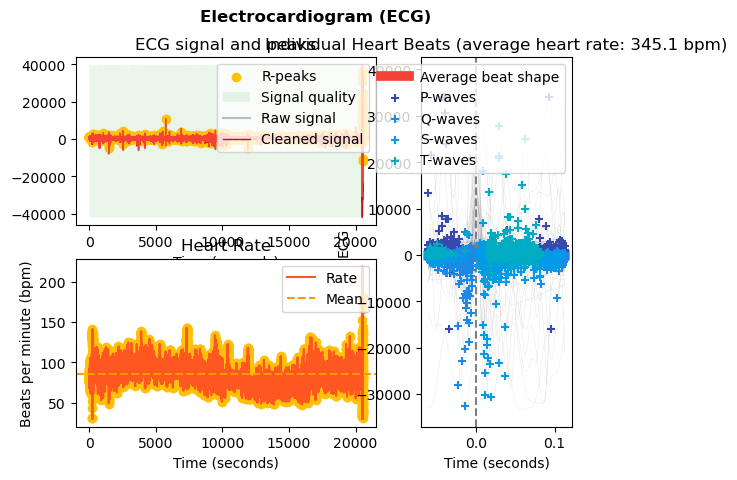

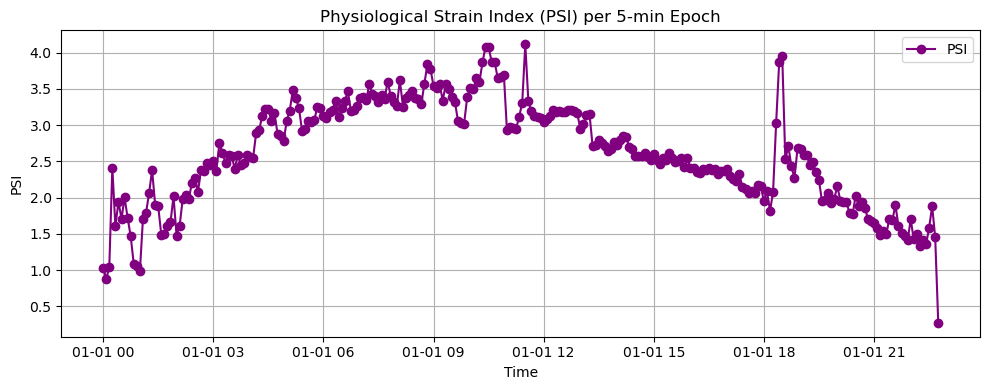

In [ ]:
if __name__ == "__main__":
    filepath = "./keep.11-02-45.edf"
    participant_id = os.path.splitext(os.path.basename(filepath))[0]

    print(f"Processing: {participant_id}")

    # Step 1: Load + clean ECG
    ecg_signal, sampling_rate = load_ecg_from_edf(filepath)
    ecg_signals, ecg_info = clean_and_detect_peaks(ecg_signal)

    # Step 2: Remove bad readings or poor contact sections
    ecg_signals = clean_hr_flatlines(ecg_signals)

    # Step 3: Add timing info for each row
    ecg_signals["Time_sec"] = ecg_signals.index / sampling_rate
    ecg_signals["Epoch"] = (ecg_signals["Time_sec"] // 300).astype(int)
    ecg_signals["Epoch_Start"] = pd.to_datetime(ecg_signals["Epoch"] * 300, unit="s")
    ecg_signals["Participant"] = participant_id

    # Step 4: Visual check of ECG signal
    plot_ecg_with_peaks(ecg_signals)

    # Step 5: Calculate detailed HRV for each 5-min block
    hrv_epoch = compute_5min_hrv(np.array(ecg_info["ECG_R_Peaks"]))
    hrv_epoch["Epoch_Start"] = pd.to_datetime(hrv_epoch["Epoch"] * 300, unit="s")
    hrv_epoch["HR_BPM"] = 60000 / hrv_epoch["HRV_MeanNN"]  # I convert NN intervals to beats/min

    # Step 6: Simulate CBT for testing PSI calculation
    hrv_epoch["CBT"] = TEMP_REST + 1.2 * np.sin(np.linspace(0, np.pi, len(hrv_epoch)))

    # Step 7: Compute PSI per epoch
    hrv_epoch["PSI"] = calculate_psi(hrv_epoch["HR_BPM"], hrv_epoch["CBT"])
    hrv_epoch["Participant"] = participant_id

    # Step 8: Basic stats per epoch (mean HR etc.)
    ecg_summary = summarize_ecg_per_epoch(ecg_signals)
    ecg_summary["Participant"] = participant_id

    # Step 9: Plot PSI across the timeline
    plt.figure(figsize=(10, 4))
    plt.plot(hrv_epoch["Epoch_Start"], hrv_epoch["PSI"], marker='o', label="PSI", color='purple')
    plt.title("Physiological Strain Index (PSI) per 5-min Epoch")
    plt.xlabel("Time")
    plt.ylabel("PSI")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Step 10: Export to CSV, this might be helpful for merging with CBT or other logs
    ecg_signals.to_csv(f"{participant_id}_ecg_signals_5min_cleaned.csv", index=False)
    hrv_epoch.to_csv(f"{participant_id}_hrv_5min_with_psi.csv", index=False)
    ecg_summary.to_csv(f"{participant_id}_ecg_summary_5min.csv", index=False)

